# INTRODUCTION

> This study focuses on model assessments for forecasting the VNINDEX (Vietnam Stock Market Index) by leveraging insights from the S&P 500 (US Stock Market Index). The primary goal is to identify an appropriate model that accurately predicts VNINDEX movements, enabling informed investment decisions and a deeper understanding of Vietnam's economic trajectory.

The inclusion of the S&P 500 as a key variable stems from the distinct characteristics of the two markets. The US market, being a developed market, serves as a benchmark for comparison and offers valuable insights into global economic trends. This comparative analysis will shed light on the applicability and effectiveness of forecasting models across different market structures.

Furthermore, we explore the potential of using VNINDEX forecasts to gain insights into Vietnam's GDP growth. The rationale behind this lies in the security market's inherent sensitivity to economic conditions. Stock market trends often reflect broader economic sentiment and can serve as leading indicators of economic expansion or contraction. By establishing a robust forecasting model for VNINDEX, we aim to indirectly gauge potential trends in Vietnam's GDP growth, providing valuable information for economic planning and policy formulation.

This research will delve into various time series models, statistical techniques, and econometric approaches to identify the most suitable model for forecasting VNINDEX. The findings will not only contribute to investment strategies but also offer a broader perspective on the interconnectedness of global and local economies, with a specific focus on the dynamic relationship between the US and Vietnam.

# INSTALLMENT

**1. Install required libraries**

In [4]:
!pip install requests pandas numpy matplotlib seaborn altair scikit-learn statsmodels


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


📌 Explanation:

- `requests`: For making HTTP requests (useful for fetching API data).
- `pandas`, `numpy`: For data manipulation.
- `matplotlib`, `seaborn`, `altair`: For data visualization.
- `scikit-learn`: For machine learning (Random Forest, train/test split).
- `statsmodels`: For time series analysis (ARIMA, ADF test, ACF/PACF).

**2. Optimized Code**

After installation, import the libraries like this:

In [5]:
# Basic utilities
import requests
import json
import time
import numpy as np
import pandas as pd

# Machine Learning & Statistical Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


**3. Set up library for data preparation of Machine Learning Models**

In [6]:
# Processing time series data, training a model (Random Forest)
class TimeSeriesProcessor:
    def __init__(self, data, num_lags, train_test_split):
        self.data = data
        self.num_lags = num_lags
        self.train_test_split = train_test_split
        self.x_train, self.y_train, self.x_test, self.y_test = self.data_preprocessing()

    def data_preprocessing(self):
        """Prepares the data for training by creating lagged features."""
        x, y = [], []
        for i in range(len(self.data) - self.num_lags):
            x.append(self.data[i:i + self.num_lags])
            y.append(self.data[i + self.num_lags])

        # Convert to numpy arrays
        x, y = np.array(x), np.array(y)

        # Split into training and testing sets
        split_index = int(self.train_test_split * len(x))
        x_train, y_train = x[:split_index], y[:split_index]
        x_test, y_test = x[split_index:], y[split_index:]

        return x_train, y_train, x_test, y_test

    @staticmethod
    def plot_train_test_values(window, train_window, y_train, y_test, y_predicted):
        """Plots training, test, and predicted values."""
        prediction_window = window
        first = train_window
        second = window - first

        # Reshape for plotting
        y_predicted = np.reshape(y_predicted, (-1, 1))
        y_test = np.reshape(y_test, (-1, 1))

        # Create an array for plotting
        plotting_time_series = np.zeros((prediction_window, 3))
        plotting_time_series[0:first, 0] = y_train[-first:]
        plotting_time_series[first:, 1] = y_test[:second, 0]
        plotting_time_series[first:, 2] = y_predicted[:second, 0]
        plotting_time_series[:first, 1:] = np.nan
        plotting_time_series[first:, 0] = np.nan

        # Set figure size
        plt.figure(figsize=(12,6))

        # Plot
        plt.plot(plotting_time_series[:, 0], label='Training data', color='#143D60', linewidth=2.5)
        plt.plot(plotting_time_series[:, 1], label='Test data', color='#143D60', linestyle='dashed', linewidth=2)
        plt.plot(plotting_time_series[:, 2], label='Predicted data', color='red', linewidth=1)
        plt.axvline(x=first, color='black', linestyle='--', linewidth=1)
        plt.grid()
        plt.legend()
        plt.show()

    @staticmethod
    def calculate_accuracy(predicted_returns, real_returns):
        """Calculates accuracy by comparing predicted and actual signs."""
        predicted_returns = np.reshape(predicted_returns, (-1, 1))
        real_returns = np.reshape(real_returns, (-1, 1))

        hits = np.sum(np.sign(predicted_returns) == np.sign(real_returns))
        accuracy = (hits / len(predicted_returns)) * 100
        return accuracy

    @staticmethod
    def model_bias(predicted_returns):
        """Calculates model bias by comparing bullish vs bearish forecasts."""
        bullish_forecasts = np.sum(predicted_returns > 0)
        bearish_forecasts = np.sum(predicted_returns < 0)
        return bullish_forecasts / bearish_forecasts if bearish_forecasts != 0 else np.inf
    def train_random_forest(self):
        """Trains a Random Forest Regressor model."""
        model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
        model.fit(self.x_train, self.y_train)
        return model

# DATA SCRAPING USING API

> Below codes provide a robust and efficient way to download historical stock data from Vietcap (VNINDEX) and Yahoo Finance (S&P500), handling potential rate limits and data format inconsistencies.  The use of Pandas makes the data easy to manipulate and analyze further.  The error handling ensures the script is more resilient to network issues and unexpected API responses.


 This Python code retrieves historical stock data for the VNINDEX from the [Vietcap API_website](https://trading.vietcap.com.vn/?type=stock&filter-value=VN30&filter-group=HOSE&view-type=FLAT) and formats it into a Pandas DataFrame.  

**1. `fetch_vietcap(symbol, timeframe="ONE_DAY", count_back=3850, to_timestamp=1739491200, delay=1)` function:**

* **Parameters:**
    * `symbol`: The stock symbol (e.g., "VNINDEX").
    * `timeframe`: The timeframe for the data (default is "ONE_DAY").  This would need to be adjusted if the API supports other timeframes (e.g., "ONE_HOUR", "ONE_MINUTE").
    * `count_back`: The number of data points to retrieve (default is 3850, approximately 10 years of daily data).
    * `to_timestamp`: The end timestamp for the data (default is a Unix timestamp corresponding to a specific date; you should adjust this to fetch data for the desired period).
    * `delay`:  A delay (in seconds) added to avoid overwhelming the Vietcap API with requests (default is 1 second).

* **API Interaction:**
    * It constructs a POST request to the Vietcap API endpoint (`https://trading.vietcap.com.vn/api/chart/OHLCChart/gap-chart`).
    * The `payload` is a JSON object containing the request parameters (symbol, timeframe, number of data points, and end timestamp).
    * It includes necessary headers, especially a `User-Agent` to identify the request as coming from a browser (important to avoid being blocked by the API).
    * It handles potential errors by checking the response status code. If the status code is not 200 (OK), it raises an exception.
    * A `time.sleep(delay)` is included to introduce a delay between requests, preventing the application from overloading the server.

* **Data Processing:**
    * The JSON response is converted into a Pandas DataFrame.  The response is likely nested, so `.explode(['o', 'h', 'l', 'c', 'v', 't'])` flattens the nested lists for open, high, low, close, volume, and timestamp.
    * The columns are renamed to more descriptive names (`time`, `open`, `high`, `low`, `close`, `volume`).
    * The `time` column is converted to datetime objects using `pd.to_datetime`.
    * The numerical columns (`open`, `high`, `low`, `close`, `volume`) are converted to numeric data types using `pd.to_numeric`, handling potential errors (e.g., non-numeric values) gracefully.
    * The DataFrame is set to use the `time` column as the index and includes only the relevant columns.
    * Finally, it adds a column `index` to store the symbol  for easy reference when dealing with multiple symbols.


**2. Data Fetching and Display:**

* `vnindex = fetch_vietcap('VNINDEX')` calls the function to retrieve VNINDEX data.
* `vnindex` displays the resulting DataFrame containing the historical stock data.

In [7]:
def fetch_vietcap(symbol, timeframe="ONE_DAY", count_back=3850, to_timestamp=1739491200, delay=1):
    """Fetch VNINDEX stock data from Vietcap API."""
    url = "https://trading.vietcap.com.vn/api/chart/OHLCChart/gap-chart"
    
    payload = json.dumps({
        "timeFrame": timeframe,
        "symbols": [symbol],
        "countBack": count_back,
        "to": to_timestamp
    })
    
    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "application/json",
        "Content-Type": "application/json"
    }
    
    response = requests.post(url, headers=headers, data=payload)
    time.sleep(delay)  # Add delay to avoid rate limits
    
    if response.status_code != 200:
        raise Exception(f"Error {response.status_code}: {response.reason}")
    
    df = pd.DataFrame(response.json()).explode(['o', 'h', 'l', 'c', 'v', 't']).rename(columns={
        't': 'time', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'
    })
    
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].apply(pd.to_numeric, errors='coerce')
    
    return df.set_index('time')[['open', 'high', 'low', 'close', 'volume']].assign(index=symbol)

# Fetch VNINDEX data
vnindex = fetch_vietcap('VNINDEX')

# Display result
vnindex


C:\Users\votranhuonggiang\AppData\Local\Temp\ipykernel_25304\1183982074.py:28: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['time'] = pd.to_datetime(df['time'], unit='s')


,open,high,low,close,volume,index
time,,,,,,
2013-01-02,415.50,419.05,414.41,418.35,64288223,VNINDEX
2013-01-03,420.68,420.68,413.68,419.27,99824757,VNINDEX
2013-01-04,418.75,426.48,417.50,426.06,64852320,VNINDEX
2013-01-07,428.84,434.64,426.86,434.19,78123432,VNINDEX
2013-01-08,437.25,447.16,437.15,447.16,119101143,VNINDEX
...,...,...,...,...,...,...
2025-02-10,1275.20,1275.20,1263.26,1263.26,794054460,VNINDEX
2025-02-11,1263.26,1268.45,1263.11,1268.45,622260600,VNINDEX
2025-02-12,1268.45,1272.86,1266.59,1266.91,504507839,VNINDEX


This Python code fetches historical stock data from [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/) for a given symbol (e.g., "^GSPC" for the S&P 500 index).

**1. Function Definition: `fetch_yahoo_finance(symbol, start, end, interval, max_retries)`**

This function takes several arguments:

* `symbol`:  The stock ticker symbol (e.g., "AAPL", "^GSPC").
* `start`: The starting date for the data (default: "2013-01-01").
* `end`: The ending date for the data (default: "2025-02-12").
* `interval`: The data frequency ("1d" for daily, "1wk" for weekly, etc., default: "1d").
* `max_retries`: The maximum number of attempts to make in case of network errors (default: 5).


**2. Date Conversion and URL Construction:**

The code converts the `start` and `end` dates into Unix timestamps (seconds since the epoch), which are required by the Yahoo Finance API.  It then constructs the API URL using an f-string, incorporating the symbol, timestamps, and interval.

**3. HTTP Request with Retry Mechanism:**

A `requests.Session()` is used to manage the HTTP connection.  The code includes a crucial retry loop. If a request returns a 429 status code (indicating a rate limit from Yahoo Finance), it waits for an exponentially increasing period (5, 10, 15, etc. seconds) before retrying.  This prevents the script from being blocked by the server. Other HTTP errors raise an exception.

**4. JSON Parsing and Data Validation:**

The JSON response from Yahoo Finance is parsed. The code checks for the presence of essential keys ("timestamp" and "indicators") to ensure the data is in the expected format.  If the format is invalid, a `ValueError` is raised.

**5. Data Transformation and Cleaning:**

The relevant data (open, high, low, close, volume, etc.) is extracted from the JSON and converted into a Pandas DataFrame. The "timestamp" is converted to a datetime index.  Finally, rows with any missing values (`dropna()`) are removed, and a column indicating the stock symbol is added.

**6. S&P 500 Data Fetch and Display:**

The `fetch_yahoo_finance` function is called to retrieve S&P 500 data ("^GSPC"), and the resulting DataFrame is displayed.

In [8]:
def fetch_yahoo_finance(symbol, start="2013-01-01", end="2025-02-12", interval="1d", max_retries=5):
    # Convert date strings to UNIX timestamps
    period1 = int(pd.Timestamp(start).timestamp())
    period2 = int(pd.Timestamp(end).timestamp())

    url = f"https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?period1={period1}&period2={period2}&interval={interval}"
    headers = {"User-Agent": "Mozilla/5.0"}

    session = requests.Session()
    session.headers.update(headers)

    # Retry logic for rate limits (HTTP 429)
    for attempt in range(max_retries):
        response = session.get(url)
        if response.status_code == 200:
            break
        elif response.status_code == 429:
            time.sleep(5 * (attempt + 1))  # Exponential backoff
        else:
            raise Exception(f"Error {response.status_code}: {response.reason}")

    # Parse JSON response
    data = response.json().get("chart", {}).get("result", [{}])[0]
    if "timestamp" not in data or "indicators" not in data:
        raise ValueError("Invalid response format")

    # Convert to DataFrame
    df = pd.DataFrame(data["indicators"]["quote"][0])
    df["time"] = pd.to_datetime(data["timestamp"], unit="s").normalize()
    df.set_index("time", inplace=True)

    # Drop missing values & add symbol column
    return df.dropna().assign(index=symbol)

# Fetch S&P 500 data
sp500 = fetch_yahoo_finance("^GSPC")

# Display results
sp500


,high,volume,open,low,close,index
time,,,,,,
2013-01-02,1462.430054,4202600000,1426.189941,1426.189941,1462.420044,^GSPC
2013-01-03,1465.469971,3829730000,1462.420044,1455.530029,1459.369995,^GSPC
2013-01-04,1467.939941,3424290000,1459.369995,1458.989990,1466.469971,^GSPC
2013-01-07,1466.469971,3304970000,1466.469971,1456.619995,1461.890015,^GSPC
2013-01-08,1461.890015,3601600000,1461.890015,1451.640015,1457.150024,^GSPC
...,...,...,...,...,...,...
2025-02-05,6062.859863,4756250000,6020.450195,6007.060059,6061.479980,^GSPC
2025-02-06,6084.029785,4847120000,6072.220215,6046.830078,6083.569824,^GSPC
2025-02-07,6101.279785,4766900000,6083.129883,6019.959961,6025.990234,^GSPC


**Data Type Verification:**

> This section of the script performs a comprehensive comparison of the data types for each corresponding column
between the VNINDEX and SP500 datasets. The purpose of this analysis is to ensure data consistency and
compatibility before proceeding with any further analysis or modeling tasks. It addresses concerns that data pulled
from different sources (VietCap and Yahoo Finance) must be consistent.

Any differences identified in this step are investigated and addressed to maintain data integrity and prevent potential errors in subsequent operations. Therefore, the verification below is qualified and the dataset would be used directly for the analysis.

In [9]:
# Check data types of VNINDEX and SP500 columns
print("---VNINDEX data types---\n", vnindex.dtypes)
print("\n---SP500 data types---\n", sp500.dtypes)

# Compare data types
vnindex_types = vnindex.dtypes.to_dict()
sp500_types = sp500.dtypes.to_dict()

print("\n---Data type comparison---")
for col in vnindex_types:
    if col in sp500_types:
      print(f"{col}: VNINDEX ({vnindex_types[col]}) vs SP500 ({sp500_types[col]}) - {'Same' if vnindex_types[col] == sp500_types[col] else 'Different'}")
    else:
      print(f"{col} is present in VNINDEX but not in SP500.")

for col in sp500_types:
    if col not in vnindex_types:
        print(f"{col} is present in SP500 but not in VNINDEX.")

---VNINDEX data types---
 open      float64
high      float64
low       float64
close     float64
volume      int64
index      object
dtype: object

---SP500 data types---
 high      float64
volume      int64
open      float64
low       float64
close     float64
index      object
dtype: object

---Data type comparison---
open: VNINDEX (float64) vs SP500 (float64) - Same
high: VNINDEX (float64) vs SP500 (float64) - Same
low: VNINDEX (float64) vs SP500 (float64) - Same
close: VNINDEX (float64) vs SP500 (float64) - Same
volume: VNINDEX (int64) vs SP500 (int64) - Same
index: VNINDEX (object) vs SP500 (object) - Same


# DATA ANALYSIS

**_1. Graphing data and recognizing the relationship between S&P500 and VNINDEX._**

**_Key insights:_**  
* **Parallel Price Trends**: S&P 500 and VNINDEX prices generally move together.
* **VNINDEX More Volatile**: VNINDEX price swings are larger than S&P 500.
* **Diverging Volume**: S&P 500 volume is consistently high, VNINDEX volume surged in late 2020.
* **COVID-19 Hypothesis**: VNINDEX volume surge potentially linked to increased retail investing during the pandemic.

The graphs depict the price and volume trends of the S&P 500 and the VNINDEX from 2013 to 2025.  Visually, both indices exhibit the same trend with a generally upward trajectory. However, the magnitude of price changes differs, with the VNINDEX showing more volatile swings compared to the smoother, more gradual growth of the S&P 500. This is reasonable with a young security market in Vietnam compared to a mature market in US.  

Examining the volume patterns reveals a key distinction: the S&P 500's volume fluctuates consistently between roughly 5 and 10 billion, while the VNINDEX volume remained relatively subdued until late 2020, after which it experienced a significant surge from around 0.5 billion to 1.5 billion. This late 2020 increase in VNINDEX volume potentially reflects the impact of the COVID-19 pandemic, which may have driven increased participation in the Vietnamese stock market due to factors such as stay-at-home orders, low interest rates, and a search for alternative investment opportunities.

In [10]:
# Reset index for plotting
sp500 = sp500.reset_index()
vnindex = vnindex.reset_index()

def create_chart(df, title):
    base = alt.Chart(df).encode(x='time:T')

    # Define background shading for multiple periods
    background_data = pd.DataFrame({
        'start': ['2014-01-01', '2018-01-01', '2022-01-01'],
        'end': ['2015-12-31', '2019-12-31', '2023-12-31'],
        'color': ['lightgrey', 'lightgrey', 'lightgrey']
    })

    background = alt.Chart(background_data).mark_rect(opacity=0.3).encode(
        x='start:T',
        x2='end:T',
        color=alt.Color('color:N', scale=None)  # Keep color mapping fixed
    )

    # Volume bar chart (Secondary y-axis)
    volume_chart = base.mark_bar(color='#143D60', size=3).encode(
        y=alt.Y('volume:Q',
                axis=alt.Axis(title='Volume', orient='right', titleColor='black', tickCount=10),
                scale=alt.Scale(domain=[0, df['volume'].max() * 3.5], nice=False))
    )

    # Closing price line chart (Primary y-axis)
    close_chart = base.mark_line(color='#578FCA', strokeWidth=2).encode(
        y=alt.Y('close:Q', axis=alt.Axis(title='Closing Price (points)', titleColor='black'))
    )

    # Combine all layers
    combined_chart = (
        alt.layer(background, volume_chart, close_chart)
        .resolve_scale(y='independent')
        .properties(title=title, width=800, height=400)
    )

    return combined_chart

# Create individual charts
sp500_chart = create_chart(sp500, "S&P 500 Price & Volume")
vnindex_chart = create_chart(vnindex, "VNINDEX Price & Volume")

# Stack the charts vertically
final_chart = alt.vconcat(sp500_chart, vnindex_chart).configure_view(
    strokeWidth=0  # Remove default border
)

# Display the final chart
final_chart


alt.VConcatChart(...)

**_2. Data processing_**

> 

In [ ]:
# Observe the dataset
print(vnindex)
print(sp500)

           time     open     high      low    close     volume    index
0    2013-01-02   415.50   419.05   414.41   418.35   64288223  VNINDEX
1    2013-01-03   420.68   420.68   413.68   419.27   99824757  VNINDEX
2    2013-01-04   418.75   426.48   417.50   426.06   64852320  VNINDEX
3    2013-01-07   428.84   434.64   426.86   434.19   78123432  VNINDEX
4    2013-01-08   437.25   447.16   437.15   447.16  119101143  VNINDEX
...         ...      ...      ...      ...      ...        ...      ...
3015 2025-02-10  1275.20  1275.20  1263.26  1263.26  794054460  VNINDEX
3016 2025-02-11  1263.26  1268.45  1263.11  1268.45  622260600  VNINDEX
3017 2025-02-12  1268.45  1272.86  1266.59  1266.91  504507839  VNINDEX
3018 2025-02-13  1266.91  1270.67  1263.85  1270.35  511055562  VNINDEX
3019 2025-02-14  1272.15  1280.60  1272.15  1276.08  647411257  VNINDEX

[3020 rows x 7 columns]
           time         high      volume         open          low  \
0    2013-01-02  1462.430054  4202600000 

Non-stability of database --> differenciate

Calculation of Differenciating for Close price

In [ ]:
# Calculate returns
sp500['close_pct'] = sp500['close'].pct_change()*100
vnindex['close_pct'] = vnindex['close'].pct_change()*100
# Drop NaN rows
sp500 = sp500.dropna(subset=['close_pct'])
vnindex = vnindex.dropna(subset=['close_pct'])

C:\Users\votranhuonggiang\AppData\Local\Temp\ipykernel_7948\583581594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['close_pct'] = sp500['close'].pct_change()*100
C:\Users\votranhuonggiang\AppData\Local\Temp\ipykernel_7948\583581594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vnindex['close_pct'] = vnindex['close'].pct_change()*100


In [ ]:
# Set time as index
sp500 = sp500.set_index('time')
vnindex = vnindex.set_index('time')

In [ ]:
# Merge the DataFrames based on the 'time' column
database = pd.merge(sp500, vnindex, on='time', suffixes=('_sp500', '_vnindex'))

# Select only the desired columns
database = database[['close_pct_sp500', 'close_pct_vnindex']]
database_vnindex = database[['close_pct_vnindex']]
database_sp500 = database[['close_pct_sp500']]


Descriptive statistics

In [ ]:
# Compute summary statistics
pd.options.display.float_format = '{:,.2f}'.format 
summary_stats = database.describe()  
summary_stats

,close_pct_sp500,close_pct_vnindex
count,"2,923.00","2,923.00"
mean,0.05,0.04
std,1.07,1.13
min,-11.98,-6.67
25%,-0.36,-0.43
50%,0.07,0.12
75%,0.56,0.64
max,9.38,4.98


Key Insights:
Compare the mean values: Which index has higher average returns?
Compare the standard deviation (volatility): Which index is more volatile?
Look at min & max values: Which index experiences larger extreme moves?
Check for skewness (asymmetry) and kurtosis (fat tails) if needed.

Histogram & Density Plot

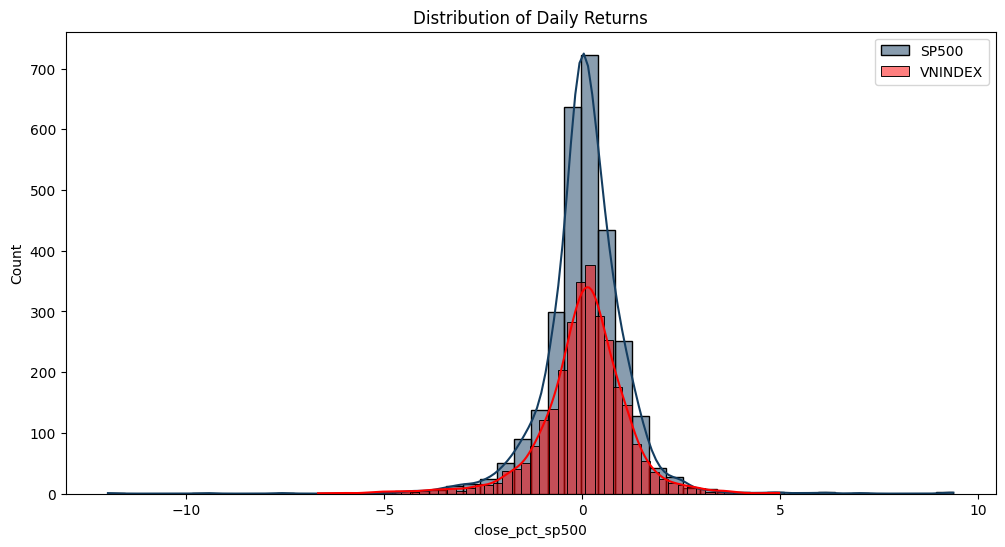

In [ ]:
plt.figure(figsize=(12,6))
sns.histplot(database['close_pct_sp500'], bins=50, kde=True, color='#143D60', label="SP500")
sns.histplot(database['close_pct_vnindex'], bins=50, kde=True, color='red', label="VNINDEX")
plt.legend()
plt.title("Distribution of Daily Returns")
plt.show()


Key Insights:
Are returns normally distributed or skewed?
Do both indices have similar volatilities, or does one show wider tails?
Are there extreme outliers indicating market shocks?

Time Series Plot

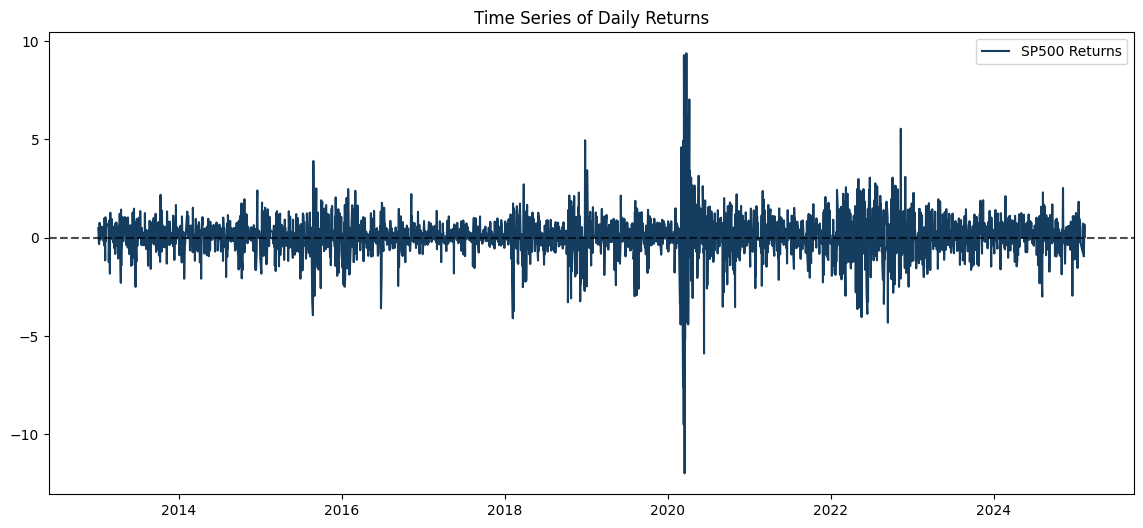

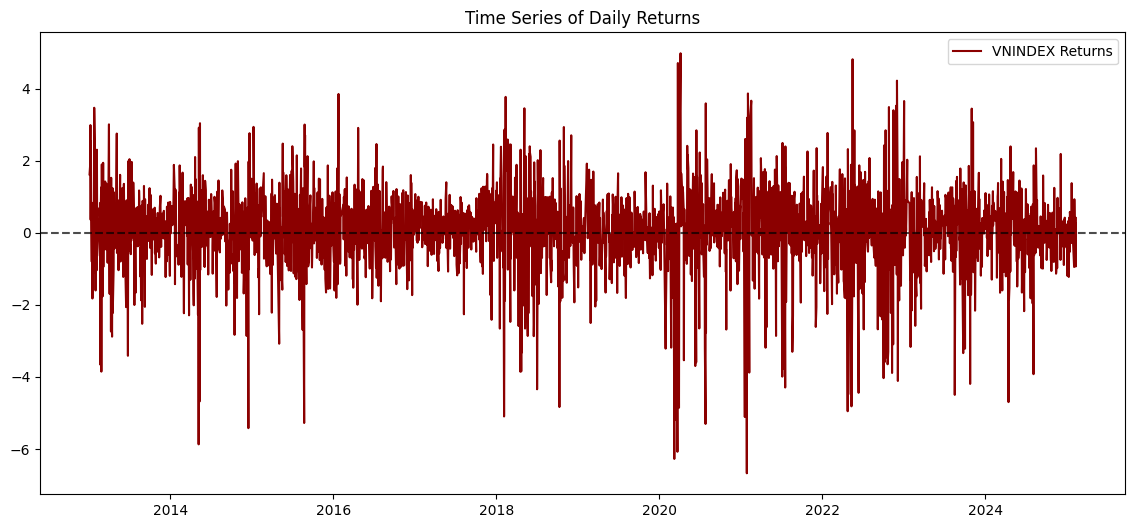

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(database.index, database['close_pct_sp500'], label='SP500 Returns', color='#143D60')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.legend()
plt.title("Time Series of Daily Returns")
plt.show()

plt.figure(figsize=(14,6))
plt.plot(database.index, database['close_pct_vnindex'], label='VNINDEX Returns', color='darkred')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.legend()
plt.title("Time Series of Daily Returns")
plt.show()


Key Insights:
Are there periods of high volatility?
Do both indices react similarly to market events?
Is there a trend or clustering of returns?

However, the correlation is very low nearly 0. Therefore, choosing standard economics methods, whose correctness is based on much correlation between variables, would be not appropriate to analyse this database.

In [ ]:
# Compute correlation and covariance of close_pct columns
correlation = database['close_pct_sp500'].corr(database['close_pct_vnindex'])
covariance = database['close_pct_sp500'].cov(database['close_pct_vnindex'])
print(f"Correlation: {correlation}")
print(f"Covariance: {covariance}")

Correlation: 0.0973765905422871
Covariance: 0.11710161499266074


In [ ]:
database_vnindex

,close_pct_vnindex
time,
2013-01-03,0.22
2013-01-04,1.62
2013-01-07,1.91
2013-01-08,2.99
2013-01-09,0.36
...,...
2025-02-05,0.39
2025-02-06,0.15
2025-02-07,0.29
